In [1]:
import os
print(os.getcwd())
os.chdir(os.path.join(os.path.dirname(os.getcwd()), "src"))
print(os.getcwd()) 


/home/mbortkie/repos/crl_subgoal/notebooks
/home/mbortkie/repos/crl_subgoal/src


In [2]:
import functools
import os

import wandb
import distrax

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

import jax
import jax.numpy as jnp
from jax import random
from typing import Tuple, Dict, Any
from dataclasses import dataclass
import chex
from flax import struct
from absl import app, flags
from ml_collections import config_flags
from impls.agents import agents
from config import SRC_ROOT_DIR
from envs.block_moving_env import *
from train import *
from impls.utils.checkpoints import restore_agent, save_agent
from config import Config, ExpConfig
from envs import legal_envs


In [3]:
EPISODE_LENGTH = 100
NUM_ENVS = 8

In [4]:
config = Config(
    exp=ExpConfig(seed=0, name="test"),
    env=BoxPushingConfig(
        grid_size=5,
        number_of_boxes_min=3,
        number_of_boxes_max=7,
        number_of_moving_boxes_max=5
    )
)

In [5]:
config

Config(exp=ExpConfig(name='test', project='crl_subgoal', mode='online', entity=None, num_envs=1024, batch_size=1024, seed=0, max_replay_size=10000, epochs=10, intervals_per_epoch=100, updates_per_rollout=1000, use_targets=False, use_double_batch_trick=False, gamma=0.99, eval_different_box_numbers=False, eval_mirrored=False, num_gifs=1, save_dir=None, gif_every=10), env=BoxPushingConfig(grid_size=5, number_of_boxes_min=3, number_of_boxes_max=7, number_of_moving_boxes_max=5, episode_length=100, truncate_when_success=False, dense_rewards=False, level_generator='default', generator_mirroring=False), agent=actor_hidden_dims: &id001 !!python/tuple
- 256
- 256
actor_log_q: true
actor_loss: awr
agent_name: crl
alpha: 0.1
batch_size: 256
const_std: true
discount: 0.99
discrete: true
encoder: null
expectile: 0.9
latent_dim: 64
layer_norm: true
lr: 0.0003
tau: 0.005
use_next_obs: false
value_hidden_dims: *id001
)

In [6]:
env = create_env(config.env)
env = AutoResetWrapper(env)
key = random.PRNGKey(config.exp.seed)
env.step = jax.jit(jax.vmap(env.step))
env.reset = jax.jit(jax.vmap(env.reset))
partial_flatten = functools.partial(flatten_batch, get_next_obs=config.agent.use_next_obs)
jitted_flatten_batch = jax.jit(jax.vmap(partial_flatten, in_axes=(None, 0, 0)), static_argnums=(0,))

dummy_timestep = env.get_dummy_timestep(key)

replay_buffer = jit_wrap(
    TrajectoryUniformSamplingQueue(
        max_replay_size=config.exp.max_replay_size,
        dummy_data_sample=dummy_timestep,
        sample_batch_size=config.exp.batch_size,
        num_envs=config.exp.num_envs,
        episode_length=config.env.episode_length,
    )
)
buffer_state = jax.jit(replay_buffer.init)(key)

example_batch = {
    'observations':dummy_timestep.grid.reshape(1, -1),  # Add batch dimension 
    'next_observations': dummy_timestep.grid.reshape(1, -1),
    'actions': jnp.ones((1,), dtype=jnp.int8) * (env._env.action_space-1), # TODO: make sure it should be the maximal value of action space  # Single action for batch size 1
    'rewards': dummy_timestep.reward.reshape(1, -1),
    'masks': 1.0 - dummy_timestep.reward.reshape(1, -1), 
    'value_goals': dummy_timestep.grid.reshape(1, -1),
    'actor_goals': dummy_timestep.grid.reshape(1, -1),
}

In [7]:
agent, config = restore_agent(example_batch, "/home/mbortkie/repos/crl_subgoal/experiments/test_generalization_sc_YHIWZ6/runs/long_moving_boxes_5_grid_5_range_3_7_alpha_0.0/", 50)

Restored from /home/mbortkie/repos/crl_subgoal/experiments/test_generalization_sc_YHIWZ6/runs/long_moving_boxes_5_grid_5_range_3_7_alpha_0.0//params_50.pkl


In [8]:
keys = random.split(random.PRNGKey(0), 8)
state, info = env.reset(keys)


In [9]:
agent.sample_actions(state.grid.reshape(state.grid.shape[0], -1), state.goal.reshape(state.goal.shape[0], -1), seed=random.PRNGKey(0))

Array([1, 2, 2, 5, 2, 0, 0, 2], dtype=int32)

In [10]:
_, info, timesteps = collect_data(agent, key, env, NUM_ENVS, EPISODE_LENGTH, use_targets=False)
timesteps = jax.tree_util.tree_map(lambda x: x.swapaxes(1, 0), timesteps)


In [11]:
timesteps.grid.shape

(8, 100, 5, 5)

In [12]:
use_targets = False


timesteps_tr = jax.lax.cond(
    use_targets,
    lambda: timesteps.replace(),
    lambda: timesteps.replace(
        grid=GridStatesEnum.remove_targets(timesteps.grid),
        goal=GridStatesEnum.remove_targets(timesteps.goal)
    )
)

tr_states = timesteps_tr.grid
tr_actions = timesteps_tr.action
tr_goals = timesteps_tr.goal

In [13]:
print(timesteps.grid[:,0])

[[[ 0 10  2  0  0]
  [ 2  1  1  0  0]
  [ 6  0  0  0  0]
  [ 2  0  1  2  0]
  [ 0  0  0  1  1]]

 [[ 0  2  0  0  0]
  [ 1  0  0  0  1]
  [ 6  0  1  0  0]
  [ 0  1  0  2  0]
  [ 0  2  2  0  1]]

 [[ 0  0  0  1  1]
  [ 0  0  2  0  1]
  [ 0  2  1  0  0]
  [ 3  0  0  0  0]
  [ 0  1  2  2  2]]

 [[ 0  0  1  2  2]
  [ 0  0  0  0  0]
  [ 0  0  2  3  0]
  [ 0  1  0  0  0]
  [ 0  0  1  0  0]]

 [[ 2 10  0  1  0]
  [ 0  0  0  2  0]
  [ 1  0  0  1  3]
  [ 0  0  0  0  2]
  [ 1  2  1 10  2]]

 [[ 2  0  3  0  0]
  [ 0  0  0  2  0]
  [10  1  0  1  0]
  [10  1  2  0  2]
  [ 0  1  2  0  1]]

 [[ 1  0  0  0  0]
  [ 1  0  2  0  0]
  [ 3  0  2  1  1]
  [ 2  0  0  0  0]
  [ 0  0  2  0  0]]

 [[ 0  2 10  1  0]
  [ 2  3  2  0  0]
  [ 0  1  2  0  1]
  [ 0  0  0  0  2]
  [10  0  1  0  1]]]


In [14]:
print(timesteps.action[:,:5])

[[2 3 3 2 2]
 [3 0 0 1 0]
 [2 2 2 0 3]
 [3 0 0 0 0]
 [3 0 2 1 4]
 [0 0 0 3 1]
 [1 1 2 1 1]
 [2 2 3 2 2]]


In [15]:
key, new_key = jax.random.split(key, 2)
_, info, timesteps = collect_data(agent, key, env, NUM_ENVS, EPISODE_LENGTH, use_targets=False)
timesteps = jax.tree_util.tree_map(lambda x: x.swapaxes(1, 0), timesteps)
print(timesteps.action[:,:30])

[[3 3 2 4 1 0 3 2 5 3 5 0 5 0 1 0 0 2 1 3 0 1 2 2 5 3 4 0 1 5]
 [0 3 3 4 1 0 1 0 0 2 3 2 0 1 5 1 1 4 1 1 2 2 3 2 3 5 3 0 1 3]
 [1 1 0 3 1 1 1 3 1 1 0 1 1 1 1 2 2 1 1 0 2 2 3 2 1 0 3 2 0 1]
 [1 1 4 0 2 0 0 5 1 3 5 0 5 3 4 2 3 2 3 5 0 1 2 0 1 3 3 5 4 1]
 [0 2 0 1 0 2 4 1 1 1 2 5 5 2 1 0 5 1 5 5 5 5 5 5 5 5 5 5 5 4]
 [2 4 3 1 2 2 1 1 5 1 2 3 2 3 2 3 2 3 0 3 3 1 0 2 1 3 1 2 2 0]
 [2 2 3 1 2 3 1 1 4 1 5 5 5 1 0 5 4 0 3 3 3 1 2 2 4 5 0 1 2 0]
 [2 4 2 2 5 3 2 5 1 5 1 4 0 1 3 5 5 5 4 1 4 0 2 0 0 5 5 3 0 5]]


In [16]:
print(timesteps.grid[:,0])

[[[ 0 10  2  0  0]
  [ 2  0  2  1  1]
  [ 0  0  0  1  0]
  [ 1  2  2  0  0]
  [ 0  0  3  1  0]]

 [[ 0  0  0  1  2]
  [ 0  2  2  1  0]
  [ 0  3  1  0  0]
  [ 0  2  1  0  0]
  [ 1  0  0  2  0]]

 [[ 0  1  0  0  1]
  [ 1  0  0  3  2]
  [ 0  1  1  0  2]
  [ 2  0  2  0  2]
  [ 0  0  0  0  0]]

 [[ 3  1  1  0  0]
  [ 0  2  0  2  0]
  [ 1  2  0  2  0]
  [ 0  0  0  1  0]
  [ 0  2  0  0  1]]

 [[ 0  2  1  0  3]
  [ 0  2  0  0  0]
  [ 1  2  1  2  0]
  [10  2  0  0  1]
  [ 1  0  0  0  0]]

 [[ 2  1  3  0  0]
  [ 0  0  0  0  2]
  [ 0  2  2  0  1]
  [ 0  0  1  0  1]
  [ 1  0  0  0  2]]

 [[ 0  1  1  0  1]
  [ 0  0  3  2  0]
  [ 2  2  0  0  0]
  [10  2  1  2  0]
  [ 0  1  0  0  0]]

 [[ 0  2  0  0  2]
  [ 0  1  1  3  0]
  [ 2  0  0  2  0]
  [ 1  2  0  1  0]
  [ 0  1  0  0  0]]]


In [17]:
print(timesteps.goal[:,0])

[[[ 0 10 10  0  0]
  [10  0 10  0  0]
  [ 0  0  0  0  0]
  [ 0 10 10  0  0]
  [ 0  0  3  0  0]]

 [[ 0  0  0  0 10]
  [ 0 10 10  0  0]
  [ 0  3  0  0  0]
  [ 0 10  0  0  0]
  [ 0  0  0 10  0]]

 [[ 0  0  0  0  0]
  [ 0  0  0  3 10]
  [ 0  0  0  0 10]
  [10  0 10  0 10]
  [ 0  0  0  0  0]]

 [[ 3  0  0  0  0]
  [ 0 10  0 10  0]
  [ 0 10  0 10  0]
  [ 0  0  0  0  0]
  [ 0 10  0  0  0]]

 [[ 0 10  0  0  3]
  [ 0 10  0  0  0]
  [ 0 10  0 10  0]
  [10 10  0  0  0]
  [ 0  0  0  0  0]]

 [[10  0  3  0  0]
  [ 0  0  0  0 10]
  [ 0 10 10  0  0]
  [ 0  0  0  0  0]
  [ 0  0  0  0 10]]

 [[ 0  0  0  0  0]
  [ 0  0  3 10  0]
  [10 10  0  0  0]
  [10 10  0 10  0]
  [ 0  0  0  0  0]]

 [[ 0 10  0  0 10]
  [ 0  0  0  3  0]
  [10  0  0 10  0]
  [ 0 10  0  0  0]
  [ 0  0  0  0  0]]]


# RB checks

In [18]:
data_key = random.PRNGKey(0)
_, _, timesteps = collect_data(agent, data_key, env, config.exp.num_envs, config.env.episode_length, use_targets=config.exp.use_targets)
buffer_state = replay_buffer.insert(buffer_state, timesteps)

2025-08-13 19:39:14.754464: W external/xla/xla/service/gpu/autotuning/dot_search_space.cc:200] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs?Working around this by using the full hints set instead.


In [19]:
def make_batch(buffer_state, key):
    key, batch_key, double_batch_key = jax.random.split(key, 3)
    # Sample and process transitions
    buffer_state, transitions = replay_buffer.sample(buffer_state)
    batch_keys = jax.random.split(batch_key, transitions.grid.shape[0])
    state, future_state, goal_index = jitted_flatten_batch(config.exp.gamma, transitions, batch_keys)

    state, actions, future_state, goal_index = get_single_pair_from_every_env(state, future_state, goal_index, double_batch_key, use_double_batch_trick=config.exp.use_double_batch_trick)
    if not config.exp.use_targets:
        state = state.replace(grid=GridStatesEnum.remove_targets(state.grid))
        future_state = future_state.replace(grid=GridStatesEnum.remove_targets(future_state.grid))
    # Create valid batch
    batch = {
        'observations': state.grid.reshape(state.grid.shape[0], -1),
        'next_observations': future_state.grid.reshape(future_state.grid.shape[0], -1),
        'actions': actions.squeeze(),
        'rewards': state.reward.reshape(state.reward.shape[0], -1),
        'masks': 1.0 - state.reward.reshape(state.reward.shape[0], -1), # TODO: add success and reward separately
        'value_goals': future_state.grid.reshape(future_state.grid.shape[0], -1),
        'actor_goals': future_state.grid.reshape(future_state.grid.shape[0], -1),
    }
    return buffer_state, batch

In [20]:
key, batch_key, double_batch_key = jax.random.split(key, 3)
# Sample and process transitions
buffer_state, transitions = replay_buffer.sample(buffer_state)
batch_keys = jax.random.split(batch_key, transitions.grid.shape[0])
state, future_state, goal_index = jitted_flatten_batch(config.exp.gamma, transitions, batch_keys)

In [21]:
future_state.grid.shape,  state.grid.shape

((1024, 99, 5, 5), (1024, 99, 5, 5))

In [22]:
goal_index.shape

(1024, 100)

Array([[22,  9, 24, 15, 12, 82, 28, 60, 19, 11, 62, 31, 96, 25, 84, 20,
        66, 58, 29, 32, 83, 92, 95, 33, 29, 37, 75, 70, 77, 82, 88, 54,
        68, 54, 74, 62, 72, 51, 76, 65, 56, 73, 59, 69, 50, 71, 59, 56,
        66, 76],
       [ 5,  2, 17, 58, 94, 23, 94, 36, 26, 55, 57, 66, 32, 51, 30, 46,
        86, 57, 23, 39, 52, 71, 88, 78, 36, 88, 47, 74, 50, 42, 62, 58,
        60, 83, 64, 64, 73, 74, 49, 48, 50, 67, 60, 92, 52, 64, 97, 89,
        87, 66],
       [87, 23, 25, 91, 74, 68, 19, 67, 11, 11, 66, 40, 69, 20, 18, 54,
        57, 19, 86, 72, 63, 44, 69, 40, 75, 36, 40, 58, 56, 68, 59, 56,
        35, 34, 90, 93, 73, 54, 91, 42, 98, 57, 54, 61, 56, 65, 51, 92,
        80, 81],
       [97, 66, 11, 58,  8, 68, 25, 75, 55, 71, 63, 18, 17, 28, 64, 88,
        35, 56, 31, 27, 44, 83, 90, 50, 76, 90, 63, 79, 79, 38, 35, 52,
        33, 65, 65, 42, 41, 58, 82, 51, 62, 62, 47, 59, 95, 66, 63, 59,
        76, 72],
       [20, 94, 69, 15, 53, 23, 46, 68, 33, 43, 40, 27, 27, 69, 16, 

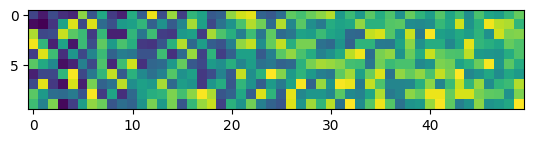

In [23]:
import matplotlib.pyplot as plt
plt.imshow(goal_index[:10, :50])
goal_index[:10, :50]

In [24]:
env_id = 0

print(state.grid.shape)

(1024, 99, 5, 5)


In [25]:
state, actions, future_state, goal_index = get_single_pair_from_every_env(state, future_state, goal_index, double_batch_key, use_double_batch_trick=config.exp.use_double_batch_trick)
if not config.exp.use_targets:
    state = state.replace(grid=GridStatesEnum.remove_targets(state.grid))
    future_state = future_state.replace(grid=GridStatesEnum.remove_targets(future_state.grid))
# Create valid batch
batch = {
    'observations': state.grid.reshape(state.grid.shape[0], -1),
    'next_observations': future_state.grid.reshape(future_state.grid.shape[0], -1),
    'actions': actions.squeeze(),
    'rewards': state.reward.reshape(state.reward.shape[0], -1),
    'masks': 1.0 - state.reward.reshape(state.reward.shape[0], -1), # TODO: add success and reward separately
    'value_goals': future_state.grid.reshape(future_state.grid.shape[0], -1),
    'actor_goals': future_state.grid.reshape(future_state.grid.shape[0], -1),
}

In [26]:
state.grid.shape

(1024, 5, 5)

In [27]:
print(state.grid[:2])

[[[11  0  1  1  0]
  [ 0  0  0  0  0]
  [ 0  0  0  0  1]
  [ 1  0  0  1  0]
  [ 0  0  0  0  0]]

 [[ 1  0  0  0  0]
  [ 0  1  1  0  0]
  [ 0  4  1  0  1]
  [ 0  0  0  0  1]
  [ 0  0  0  0  0]]]


In [28]:
print(future_state.grid[:2])

[[[ 1  4  1  1  0]
  [ 0  0  0  0  0]
  [ 0  0  0  0  1]
  [ 1  0  0  1  0]
  [ 0  0  0  0  0]]

 [[11  0  0  0  0]
  [ 0  1  1  0  0]
  [ 0  0  0  0  1]
  [ 0  0  1  0  1]
  [ 0  0  0  0  0]]]


# Update costs

In [29]:
@jax.jit
def make_batch(buffer_state, key):
    key, batch_key, double_batch_key = jax.random.split(key, 3)
    # Sample and process transitions
    buffer_state, transitions = replay_buffer.sample(buffer_state)
    batch_keys = jax.random.split(batch_key, transitions.grid.shape[0])
    state, future_state, goal_index = jitted_flatten_batch(config.exp.gamma, transitions, batch_keys)

    state, actions, future_state, goal_index = get_single_pair_from_every_env(state, future_state, goal_index, double_batch_key, use_double_batch_trick=config.exp.use_double_batch_trick)
    if not config.exp.use_targets:
        state = state.replace(grid=GridStatesEnum.remove_targets(state.grid))
        future_state = future_state.replace(grid=GridStatesEnum.remove_targets(future_state.grid))
    # Create valid batch
    batch = {
        'observations': state.grid.reshape(state.grid.shape[0], -1),
        'next_observations': future_state.grid.reshape(future_state.grid.shape[0], -1),
        'actions': actions.squeeze(),
        'rewards': state.reward.reshape(state.reward.shape[0], -1),
        'masks': 1.0 - state.reward.reshape(state.reward.shape[0], -1), # TODO: add success and reward separately
        'value_goals': future_state.grid.reshape(future_state.grid.shape[0], -1),
        'actor_goals': future_state.grid.reshape(future_state.grid.shape[0], -1),
    }
    return buffer_state, batch

@jax.jit
def update_step(carry, _):
    buffer_state, agent, key = carry
    key, batch_key = jax.random.split(key, 2)
    buffer_state, batch = make_batch(buffer_state, batch_key)
    agent, update_info = update(agent, batch)
    return (buffer_state, agent, key), update_info


@jax.jit
def train_epoch(carry, _):
    buffer_state, agent, key = carry
    key, data_key, up_key = jax.random.split(key, 3)
    _, _, timesteps = collect_data(agent, data_key, env, config.exp.num_envs, config.env.episode_length, use_targets=config.exp.use_targets, critic_temp=1)
    buffer_state = replay_buffer.insert(buffer_state, timesteps)
    (buffer_state, agent, _), _ = jax.lax.scan(update_step, (buffer_state, agent, up_key), None, length=1000)
    return (buffer_state, agent, key), None


@functools.partial(jax.jit, static_argnums=(3,))
def train_n_epochs(buffer_state, agent, key, epochs=10):
    (buffer_state, agent, key), _ = jax.lax.scan(
        train_epoch,
        (buffer_state, agent, key),
        None,
        length=epochs,
    )
    return buffer_state, agent, key

In [30]:
batch = make_batch(buffer_state, key)[1]
agent.update(batch)

2025-08-13 18:28:03.955382: W external/xla/xla/service/gpu/autotuning/dot_search_space.cc:200] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs?Working around this by using the full hints set instead.
2025-08-13 18:28:03.955664: W external/xla/xla/service/gpu/autotuning/dot_search_space.cc:200] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs?Working around this by using the full hints set instead.
2025-08-13 18:28:03.955716: W external/xla/xla/service/gpu/autotuning/dot_search_space.cc:200] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs?Working around this by using the full hints set instead.
2025-08-13 18:28:03.955729: W external/xla/xla/service/gpu/au

(CRLAgent(rng=Array([2808407654, 2873598384], dtype=uint32), network=TrainState(step=Array(5000002, dtype=int32, weak_type=True), apply_fn=<bound method Module.apply of ModuleDict(
     # attributes
     modules = {'critic': GCDiscreteBilinearCritic(
         # attributes
         hidden_dims = (256, 256)
         latent_dim = 64
         layer_norm = True
         ensemble = True
         value_exp = True
         state_encoder = None
         goal_encoder = None
         action_dim = Array(6, dtype=int8)
     ), 'actor': GCDiscreteActor(
         # attributes
         hidden_dims = (256, 256)
         action_dim = Array(6, dtype=int8)
         final_fc_init_scale = 0.01
         gc_encoder = None
     ), 'value': GCBilinearValue(
         # attributes
         hidden_dims = (256, 256)
         latent_dim = 64
         layer_norm = True
         ensemble = False
         value_exp = True
         state_encoder = None
         goal_encoder = None
     )}
 )>, model_def=ModuleDict(
    

In [31]:
num_steps = 1000

with make_batch

In [32]:
import jax
from jax import lax
import time

def scan_body(carry, _):
    buffer_state, agent, key = carry
    key, subkey = jax.random.split(key)
    batch = make_batch(buffer_state, subkey)[1]
    
    agent, metrics = agent.update(batch)  # ensure new_agent is same type as original
    return (buffer_state, agent, key), metrics  # metrics will be collected


# Setup
key = jax.random.PRNGKey(0)

# Warmup + compile
(keys_carry, agent_carry, _) , _ = lax.scan(scan_body, (buffer_state, agent, key), None, length=1)
jax.block_until_ready(keys_carry)  # Ensure compilation happens here

# Time execution
start = time.time()
(buffer_state, agent, key), _ = lax.scan(scan_body, (buffer_state, agent, key), None, length=num_steps)
jax.block_until_ready(buffer_state)  # Ensure all computation finishes
end = time.time()

print(f"Execution time: {end - start:.4f} seconds")


2025-08-13 18:28:16.021134: W external/xla/xla/service/gpu/autotuning/dot_search_space.cc:200] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs?Working around this by using the full hints set instead.
2025-08-13 18:28:29.238957: W external/xla/xla/service/gpu/autotuning/dot_search_space.cc:200] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs?Working around this by using the full hints set instead.


Execution time: 14.0280 seconds


without make batch

In [33]:
import jax
from jax import lax
import time

def scan_body(carry, _):
    buffer_state, agent, key = carry
    key, subkey = jax.random.split(key)    
    agent, metrics = agent.update(batch)  # ensure new_agent is same type as original
    return (buffer_state, agent, key), metrics  # metrics will be collected


# Setup
key = jax.random.PRNGKey(0)

# Warmup + compile
(keys_carry, agent_carry, _) , _ = lax.scan(scan_body, (buffer_state, agent, key), None, length=1)
jax.block_until_ready(keys_carry)  # Ensure compilation happens here

# Time execution
start = time.time()
(buffer_state, agent, key), _ = lax.scan(scan_body, (buffer_state, agent, key), None, length=num_steps)
jax.block_until_ready(buffer_state)  # Ensure all computation finishes
end = time.time()

print(f"Execution time: {end - start:.4f} seconds")


Execution time: 9.7255 seconds


In [ ]:
import jax
from jax import lax
from functools import partial
import time

# your original scan body — keep it pure JAX code (no host-side Python I/O)
def scan_body(carry, _):
    buffer_state, agent, key = carry
    key, subkey = jax.random.split(key)
    batch = make_batch(buffer_state, subkey)[1]

    agent, metrics = agent.update(batch)  # agent must be a JAX-friendly pytree / pure function
    return (buffer_state, agent, key), metrics  # metrics will be collected

# JIT the outer runner. num_steps is used as a static argument for lax.scan.
@partial(jax.jit, static_argnums=(3,))
def run_scan(buffer_state, agent, key, num_steps):
    (buffer_state, agent, key), metrics = lax.scan(
        scan_body, (buffer_state, agent, key), None, length=num_steps
    )
    return (buffer_state, agent, key), metrics

# Setup
key = jax.random.PRNGKey(0)

# Warmup / compile
(out, metrics) = run_scan(buffer_state, agent, key, 1)  # triggers compilation
jax.tree_util.tree_map(lambda x: x.block_until_ready(), out)
# optionally block until compilation finishes:
# jax.tree_util.tree_map(lambda x: x.block_until_ready(), run_scan(buffer_state, agent, key, 1))

# Time execution
start = time.perf_counter()
(out, metrics) = run_scan(buffer_state, agent, key, num_steps)
# Ensure all device work finished before timing
jax.tree_util.tree_map(lambda x: x.block_until_ready(), out)
end = time.perf_counter()

print(f"Execution time: {end - start:.4f} seconds")


Execution time: 14.0391 seconds


# Just actor updates

In [30]:
@jax.jit
def total_loss(agent, batch, grad_params, rng=None):
    """Compute the total loss."""
    info = {}
    rng = rng if rng is not None else agent.rng

    # critic_loss, critic_info = agent.contrastive_loss(batch, grad_params, 'critic')
    # for k, v in critic_info.items():
    #     info[f'critic/{k}'] = v

    # if agent.config['actor_loss'] == 'awr':
    #     value_loss, value_info = agent.contrastive_loss(batch, grad_params, 'value')
    #     for k, v in value_info.items():
    #         info[f'value/{k}'] = v
    # else:
    #     value_loss = 0.0

    rng, actor_rng = jax.random.split(rng)
    actor_loss, actor_info = agent.actor_loss(batch, grad_params, actor_rng)
    for k, v in actor_info.items():
        info[f'actor/{k}'] = v

    # loss = critic_loss + value_loss + actor_loss
    loss = actor_loss
    return loss, info

@jax.jit
def update(agent, batch):
    """Update the agent and return a new agent with information dictionary."""
    new_rng, rng = jax.random.split(agent.rng)

    def loss_fn(grad_params):
        return agent.total_loss(batch, grad_params, rng=rng)

    new_network, info = agent.network.apply_loss_fn(loss_fn=loss_fn)

    return agent.replace(network=new_network, rng=new_rng), info

In [31]:
def make_batch(buffer_state, key):
    key, batch_key, double_batch_key = jax.random.split(key, 3)
    # Sample and process transitions
    buffer_state, transitions = replay_buffer.sample(buffer_state)
    batch_keys = jax.random.split(batch_key, transitions.grid.shape[0])
    state, future_state, goal_index = jitted_flatten_batch(config.exp.gamma, transitions, batch_keys)

    state, actions, future_state, goal_index = get_single_pair_from_every_env(state, future_state, goal_index, double_batch_key, use_double_batch_trick=config.exp.use_double_batch_trick)
    if not config.exp.use_targets:
        state = state.replace(grid=GridStatesEnum.remove_targets(state.grid))
        future_state = future_state.replace(grid=GridStatesEnum.remove_targets(future_state.grid))
    # Create valid batch
    batch = {
        'observations': state.grid.reshape(state.grid.shape[0], -1),
        'next_observations': future_state.grid.reshape(future_state.grid.shape[0], -1),
        'actions': actions.squeeze(),
        'rewards': state.reward.reshape(state.reward.shape[0], -1),
        'masks': 1.0 - state.reward.reshape(state.reward.shape[0], -1), # TODO: add success and reward separately
        'value_goals': future_state.grid.reshape(future_state.grid.shape[0], -1),
        'actor_goals': future_state.grid.reshape(future_state.grid.shape[0], -1),
    }
    return buffer_state, batch

@jax.jit
def update_step(carry, _):
    buffer_state, agent, key = carry
    key, batch_key = jax.random.split(key, 2)
    buffer_state, batch = make_batch(buffer_state, batch_key)
    agent, update_info = update(agent, batch)
    return (buffer_state, agent, key), update_info


@jax.jit
def train_epoch(carry, _):
    buffer_state, agent, key = carry
    key, data_key, up_key = jax.random.split(key, 3)
    _, _, timesteps = collect_data(agent, data_key, env, config.exp.num_envs, config.env.episode_length, use_targets=config.exp.use_targets, critic_temp=1)
    buffer_state = replay_buffer.insert(buffer_state, timesteps)
    (buffer_state, agent, _), _ = jax.lax.scan(update_step, (buffer_state, agent, up_key), None, length=1000)
    return (buffer_state, agent, key), None


@functools.partial(jax.jit, static_argnums=(3,))
def train_n_epochs(buffer_state, agent, key, epochs=10):
    (buffer_state, agent, key), _ = jax.lax.scan(
        train_epoch,
        (buffer_state, agent, key),
        None,
        length=epochs,
    )
    return buffer_state, agent, key

In [33]:
import jax
from jax import lax
import time

def scan_body(carry, _):
    buffer_state, agent, key = carry
    key, subkey = jax.random.split(key)    
    agent, metrics = update(agent, batch)  # ensure new_agent is same type as original
    return (buffer_state, agent, key), metrics  # metrics will be collected


# Setup
key = jax.random.PRNGKey(0)
num_steps=1000
# Warmup + compile
(keys_carry, agent_carry, _) , _ = lax.scan(scan_body, (buffer_state, agent, key), None, length=1)
jax.block_until_ready(keys_carry)  # Ensure compilation happens here

# Time execution
start = time.time()
(buffer_state, agent, key), _ = lax.scan(scan_body, (buffer_state, agent, key), None, length=num_steps)
jax.block_until_ready(buffer_state)  # Ensure all computation finishes
end = time.time()

print(f"Execution time: {end - start:.4f} seconds")


2025-08-13 19:40:23.043669: W external/xla/xla/service/gpu/autotuning/dot_search_space.cc:200] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs?Working around this by using the full hints set instead.


Execution time: 9.7288 seconds
